In [1]:
import fastai
from fastai.vision import *
import scipy.io
from torchvision import models
from visualization.modules import LayeredModule, get_nested_layers
from visualization.data import *
from visualization.image_proc import *
from visualization.interpret import NetLens

# IMDB Dataset 
### 1) Parse MetaData from Matlab file
### 2) Explore Data and choose a random Sample
### 3) Train a Regression model on "Age"

In [2]:
import os
import numpy as np
import scipy.io as sio
import datetime 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

### 1) Parse Metadata

In [3]:
path_to_meta = Path("/home/jupyter/imdb-face-data/imdb_crop/")
matlab_file = 'imdb.mat'

In [4]:
imdb_meta = sio.loadmat(path_to_meta / matlab_file)
imdb = imdb_meta['imdb']

### Utility Function

In [5]:
def reformat_date(mat_date):
    """ Extract only the year.
        Necessary for calculating the age of the individual in the image.
    Args:
        mat_date - raw date format.
    Retrurns:
        dt - adjusted date.
    """
    # Take account for difference in convention between matlab and python.
    dt = datetime.date.fromordinal(np.max([mat_date - 366, 1])).year
    return dt

In [6]:
imdb_matlab_dob = imdb[0][0][0][0]
imdb_photo_taken = imdb[0][0][1][0]
imdb_path = imdb[0][0][2][0]
imdb_gender = imdb[0][0][3][0]
imdb_name = imdb[0][0][4][0]
imdb_full_path = [path_to_meta / path[0] for path in sorted(imdb_path)]
imdb_dob = [reformat_date(p) for p in imdb_matlab_dob]
imdb_age = [(imdb_photo_taken[n] - imdb_dob[n]) for n in range(len(imdb_dob))]

### DataFrame Constructor

In [7]:
imdb_df = pd.DataFrame(np.vstack((imdb_full_path,
                                  imdb_photo_taken,
                                  imdb_name,
                                  imdb_dob,
                                  imdb_age, 
                                  imdb_gender
                                  )).T)
imdb_df.columns = ['img_path', 'photo_taken', 'name', 'date_of_birth', 'age','gender']

In [8]:
imdb_df['name'] = imdb_df['name'].apply(lambda x: " ".join(x))

In [9]:
imdb_df = imdb_df.infer_objects()
imdb_df.dtypes

img_path          object
photo_taken        int64
name              object
date_of_birth      int64
age                int64
gender           float64
dtype: object

In [10]:
imdb_df.head()

,img_path,photo_taken,name,date_of_birth,age,gender
0,/home/jupyter/imdb-face-data/imdb_crop/00/nm00...,1968,Fred Astaire,1899,69,1.0
1,/home/jupyter/imdb-face-data/imdb_crop/00/nm00...,1970,Fred Astaire,1899,71,1.0
2,/home/jupyter/imdb-face-data/imdb_crop/00/nm00...,1968,Fred Astaire,1899,69,1.0
3,/home/jupyter/imdb-face-data/imdb_crop/00/nm00...,1968,Fred Astaire,1899,69,1.0
4,/home/jupyter/imdb-face-data/imdb_crop/00/nm00...,1968,Fred Astaire,1899,69,1.0


##### Number of images

In [11]:
len(imdb_df)

460723

##### Number of Unique Celebrities in our dataset:

In [12]:
imdb_df['name'].nunique()

20284

## Check that Metadata Image Paths is same as Images paths

In [13]:
path_to_folders = [p for p in path_to_meta.iterdir() if p.is_dir()]
path_to_images = [i for p in sorted(path_to_folders) for i in sorted(p.iterdir())]

In [14]:
imdb_full_path[0] == path_to_images[0]

True

In [15]:
imdb_full_path == path_to_images

True

__AWESOME__

### Get Image sizes

In [16]:
def get_img_size_from_file(imgfile):
    try:
        with PIL.Image.open(imgfile) as img:
            return img.size
    except:
        print("ERROR opening image: " + str(imgfile))
        return -1, -1

In [17]:
imdb_df['size (W,H)'] = imdb_df["img_path"].apply(lambda x: get_img_size_from_file(x))

In [18]:
imdb_df.head()

,img_path,photo_taken,name,date_of_birth,age,gender,"size (W,H)"
0,/home/jupyter/imdb-face-data/imdb_crop/00/nm00...,1968,Fred Astaire,1899,69,1.0,"(500, 500)"
1,/home/jupyter/imdb-face-data/imdb_crop/00/nm00...,1970,Fred Astaire,1899,71,1.0,"(171, 171)"
2,/home/jupyter/imdb-face-data/imdb_crop/00/nm00...,1968,Fred Astaire,1899,69,1.0,"(315, 315)"
3,/home/jupyter/imdb-face-data/imdb_crop/00/nm00...,1968,Fred Astaire,1899,69,1.0,"(252, 252)"
4,/home/jupyter/imdb-face-data/imdb_crop/00/nm00...,1968,Fred Astaire,1899,69,1.0,"(334, 334)"


### Let's Save original dataframe to csv file (outside of the Github repository)

In [3]:
output_path = '/home/jupyter/imdb-face-data/imdb_crop/imdb-original.csv'

In [20]:
imdb_df.to_csv(output_path, index=False, encoding='utf-8')

In [21]:
del imdb_df

In [4]:
imdb_df = pd.read_csv(output_path)

## 2) Quick Exploratory Data Analysis

### Distribution of Genders

In [5]:
imdb_df['gender'].value_counts(dropna=False)

1.0    263214
0.0    189047
NaN      8462
Name: gender, dtype: int64

#### Let's get rid off those rows with NaN Values

In [6]:
imdb_df = imdb_df.dropna(subset=['gender'])
imdb_df['gender'].value_counts(dropna=False)

1.0    263214
0.0    189047
Name: gender, dtype: int64

In [7]:
print(len(imdb_df))
imdb_df['gender'].value_counts(normalize=True)*100

452261


1.0    58.199579
0.0    41.800421
Name: gender, dtype: float64

__60% of Males and 40% of Females in original dataset__

__When Sampling, we will perform stratified sampling to get 50% of Male and 50% of Female__

### Distribution of image sizes

In [8]:
imdb_df['size (W,H)'].value_counts(ascending=False).head(10)

(500, 500)    78736
(334, 500)    13817
(333, 500)    11503
(130, 130)     6590
(303, 303)     5708
(501, 501)     5411
(325, 325)     4724
(264, 264)     4693
(111, 111)     4463
(263, 264)     4296
Name: size (W,H), dtype: int64

__When sampling, will retain only images that have at least one side equal to 500-501 pxls__

### Distribution of Age

In [9]:
imdb_df['age'].value_counts().sort_index()

-30        3
-24        4
-23        1
-20        3
-19        8
-17        4
-16        4
-15       11
-14        8
-13       26
-12       39
-11       41
-10       10
-9         7
-8         6
-7        23
-6        89
-5        14
-4         6
-3       132
-2        22
-1        30
 0        47
 1        65
 2       220
 3        70
 4        58
 5       145
 6       225
 7       281
        ... 
 109       1
 113       1
 117       2
 118       1
 119       2
 125       3
 131       1
 134       5
 135       1
 1980      1
 1989      2
 1990      6
 1992      2
 1994      2
 1998      1
 1999      2
 2001      5
 2002      1
 2003      3
 2004      9
 2005      7
 2006      3
 2007      1
 2008      6
 2009     23
 2010      9
 2011     15
 2012     13
 2013     16
 2014      2
Name: age, Length: 157, dtype: int64

__We can see a lot of mislabels (negative ages - ages over 2000 years old..), this is a known issue with this dataset.__

When Sampling and for the purpose of our Style Transfer Model, we'll keep only pictures with Age labels between __10 and 90 years old__

### Distribution of number of images grouped by celebrities

In [10]:
imdb_df['name'].value_counts().head(10)

Jennifer Aniston       827
Brad Pitt              818
Angelina Jolie         795
Courteney Cox          787
Tom Cruise             779
Robert Downey Jr.      739
Nicole Kidman          719
Neil Patrick Harris    719
Zooey Deschanel        703
Jim Parsons            696
Name: name, dtype: int64

In [11]:
imdb_df['name'].value_counts(ascending=True).head(10)

Jimmy Tatro            1
John Thomson           1
Marco St. John         1
Robert Richardson      1
Eugenia Khirivskaya    1
Ted Manson             1
Gavin Lee              1
Yasmin Mitri           1
Antony Sher            1
Lucian Msamati         1
Name: name, dtype: int64

__We can see that some celebrities are over-represented.__

__For the purpose of our Style Transfer Model, we will take a sample of the Data where we retain only 1 to 5 images per person, so our Model learn from a diverse type of faces.__ 

## 2) Let's create our Sample

Taking into consideration our experiments for effective style transfer, we will take a sample of the IMDB dataset.
The Sample will follow the following conditions:

- 1) FILTER BY IMAGES SIZES (Keep only images where at least one side is of size 500 pixels)
- 2) FILTER BY AGE (Retain only pictures where celebrities have between 10 and 90 Years old)
- 3) FILTER FOR DIVERSITY (Keep 1 to 5 pictures per celebrity, and keep only pictures that are taken in different years)
- 4) PERFORM STRATIFIED SAMPLING (GET 50% of MALE AND 50% OF FEMALE)

##### 1) FILTER BY IMAGES SIZES

In [12]:
imdb_df_500 = imdb_df[(imdb_df['size (W,H)'] == '(500, 500)') |
                      (imdb_df['size (W,H)'] == '(334, 500)') |
                      (imdb_df['size (W,H)'] == '(501, 501)') |
                      (imdb_df['size (W,H)'] == '(333, 500)')]

In [13]:
len(imdb_df_500)

109467

##### 2) FILTER BY AGE

In [14]:
imdb_df_500_age = imdb_df_500[(imdb_df_500['age'] >= 10) & (imdb_df_500['age']<= 90)]
len(imdb_df_500_age)

108761

__After filtering our dataset by image sizes and ages, we reduced it to ~ 100.000 images__

__Next, let's filter for diversity__

##### 3) FILTER FOR DIVERSITY

In [15]:
imdb_df_500_age['name'].nunique()

12181

In [16]:
imdb_df_500_age_five = imdb_df_500_age.drop_duplicates(['photo_taken','name']).groupby('name').head(5)

In [17]:
len(imdb_df_500_age_five)

27787

In [18]:
imdb_df_500_age_five['name'].nunique()

12181

__We end up with 12181 distinct celebrities, GREAT!__

In [19]:
imdb_df_500_age_five['gender'].value_counts(dropna=False)

1.0    16612
0.0    11175
Name: gender, dtype: int64

__After filtering for diversity we reduced our dataset to 27.787 images__

##### 4) PERFORM STRATIFIED SAMPLING

In [20]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n, random_state=2))
    df_.index = df_.index.droplevel(0)
    return df_

In [21]:
imdb_df_500_age_five_strat = stratified_sample_df(imdb_df_500_age_five, 'gender', 10000)

In [22]:
print(len(imdb_df_500_age_five_strat))
imdb_df_500_age_five_strat['gender'].value_counts(normalize=True)*100

20000


1.0    50.0
0.0    50.0
Name: gender, dtype: float64

__Our final sample contains 20000 images, this is largely enough for training.__

### Let's Save this final DataFrame to a CSV File

In [23]:
sample_output_path = '/home/jupyter/imdb-face-data/imdb_crop/meta-imdb-sample.csv'

imdb_df_500_age_five_strat.to_csv(sample_output_path, index=False, encoding='utf-8')

In [24]:
del imdb_df_500_age_five_strat

In [25]:
sample_df = pd.read_csv(sample_output_path)

### Distribution of Ages of our sample

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf3d0aa518>]], dtype=object)

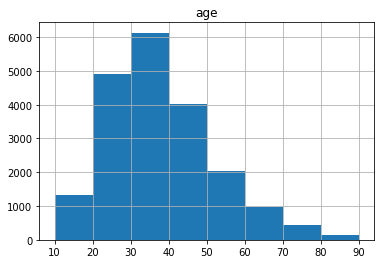

In [26]:
sample_df.hist(column=['age'], bins=8)

### Distribution of Gender

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf51d10f28>]], dtype=object)

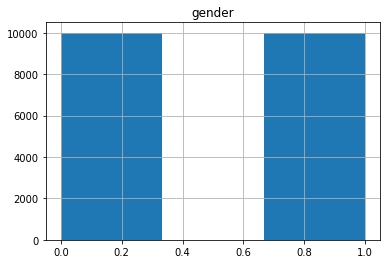

In [27]:
sample_df.hist(column=['gender'], bins=3)

## Add Parent Paths and Image paths to the Dataframe

In [28]:
DATA_PATH = Path("/home/jupyter/imdb-face-data")
DATASET_PATH = DATA_PATH / "imdb_crop"

In [29]:
sample_csv_path = '/home/jupyter/imdb-face-data/imdb_crop/meta-imdb-sample.csv'
sample_df = pd.read_csv(sample_csv_path)
sample_df.head()

,img_path,photo_taken,name,date_of_birth,age,gender,"size (W,H)"
0,/home/jupyter/imdb-face-data/imdb_crop/31/nm00...,2006,Jane Curtin,1947,59,0.0,"(500, 500)"
1,/home/jupyter/imdb-face-data/imdb_crop/61/nm11...,2009,Allisyn Ashley Arm,1996,13,0.0,"(500, 500)"
2,/home/jupyter/imdb-face-data/imdb_crop/59/nm17...,2010,Kaitlyn Dever,1996,14,0.0,"(500, 500)"
3,/home/jupyter/imdb-face-data/imdb_crop/88/nm00...,2013,Louise Monot,1981,32,0.0,"(500, 500)"
4,/home/jupyter/imdb-face-data/imdb_crop/70/nm07...,2009,Carly Rae Jepsen,1985,24,0.0,"(500, 500)"


In [30]:
sample_df['img_path'] = sample_df['img_path'].apply(lambda x: Path(x))
sample_df.rename(columns={'img_path' : 'absolute_path'}, inplace=True)
sample_df['parent_path'] = sample_df['absolute_path'].apply(lambda x: x.relative_to(DATASET_PATH))
sample_df['img_path'] = sample_df['absolute_path'].apply(lambda x: x.relative_to(x.parent))

In [31]:
sample_df.head()

,absolute_path,photo_taken,name,date_of_birth,age,gender,"size (W,H)",parent_path,img_path
0,/home/jupyter/imdb-face-data/imdb_crop/31/nm00...,2006,Jane Curtin,1947,59,0.0,"(500, 500)",31/nm0005531_rm2671491328_1969-8-17_2011.jpg,nm0005531_rm2671491328_1969-8-17_2011.jpg
1,/home/jupyter/imdb-face-data/imdb_crop/61/nm11...,2009,Allisyn Ashley Arm,1996,13,0.0,"(500, 500)",61/nm1143861_rm3018241536_1971-12-14_2012.jpg,nm1143861_rm3018241536_1971-12-14_2012.jpg
2,/home/jupyter/imdb-face-data/imdb_crop/59/nm17...,2010,Kaitlyn Dever,1996,14,0.0,"(500, 500)",59/nm1754059_rm3515611136_1982-2-11_2014.jpg,nm1754059_rm3515611136_1982-2-11_2014.jpg
3,/home/jupyter/imdb-face-data/imdb_crop/88/nm00...,2013,Louise Monot,1981,32,0.0,"(500, 500)",88/nm0004988_rm2340738560_1977-11-24_2014.jpg,nm0004988_rm2340738560_1977-11-24_2014.jpg
4,/home/jupyter/imdb-face-data/imdb_crop/70/nm07...,2009,Carly Rae Jepsen,1985,24,0.0,"(500, 500)",70/nm0704270_rm1023781120_1977-6-2_2012.jpg,nm0704270_rm1023781120_1977-6-2_2012.jpg


#### Save the Sample CSV File with those new infos

In [32]:
sample_df.to_csv('/home/jupyter/imdb-face-data/imdb_crop/imdb-sample-metafull.csv',index=False, encoding='utf-8')

### CREATE A SAMPLE DATA FOLDER (copy images from our sample csv)

In [3]:
SAMPLE_DATA_PATH = '/home/jupyter/imdb-face-data/imdb_crop/sample-imdb'

In [41]:
import shutil
import os.path

def create_sample_data_folder(source, dest):
    os.mkdir(dest)
    for path in source:
        try:
            shutil.copy2(str(path), dest)
        except:
            print(path)

In [42]:
#create_sample_data_folder(sample_df['absolute_path'], SAMPLE_DATA_PATH)

### Verify Images in our Sample

In [4]:
verify_images(SAMPLE_DATA_PATH)